## Introduction

It is very hard to quantify what exactly makes a hockey team good - although one common
trait about them is that they are always competing for the Stanley Cup in May and June.
If you ask anyone in the hockey community, there are always a few common characteristics
of these teams such as work ethic, resilience, and toughness. From the perspective of a data
scientist, these traits are hard to quantify since there is no true number to represent these.
However, there are other quantifiable factors that are influenced by these traits - these will
help us determine who will hoist the cup this year.

We look to build a model that can predict these yearly champions, specifically, the Stanley
Cup winners for the modern era of the National Hockey League (NHL). The NHL provides
access to a wide array of data involving players, teams and previous champions for over
the last century. Some categories hypothesized to have large correlations include goals for,
goals against, shots, and scoring depth. We will carefully select a set of features that heavily
influence these teams successfulness.

These tools and resources will allow us to create a supervised learning model that we
will verify by predicting a subset of the previous Stanley Cup winners. The end goal of our
model is to make a prediction for the next champion, which will be determined in June 2025.
Aside from this, we will also produce a set of likelihoods for playoff teams to win the Stanley
Cup.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (8,3)

## Data Loading

In [2]:
df = pd.read_csv('NHLTeamPlayoffStats.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              376 non-null    int64  
 1   faceoffWinPct           376 non-null    float64
 2   gamesPlayed             376 non-null    int64  
 3   goalsAgainst            376 non-null    int64  
 4   goalsAgainstPerGame     376 non-null    float64
 5   goalsFor                376 non-null    int64  
 6   goalsForPerGame         376 non-null    float64
 7   losses                  376 non-null    int64  
 8   otLosses                0 non-null      float64
 9   penaltyKillNetPct       376 non-null    float64
 10  penaltyKillPct          376 non-null    float64
 11  pointPct                376 non-null    float64
 12  points                  376 non-null    int64  
 13  powerPlayNetPct         376 non-null    float64
 14  powerPlayPct            376 non-null    fl

We will inspect certain years considered as "outliers"

In [3]:
df['seasonId'].unique()

array([20002001, 20012002, 20022003, 20032004, 20052006, 20062007,
       20072008, 20082009, 20092010, 20102011, 20112012, 20122013,
       20132014, 20142015, 20152016, 20162017, 20172018, 20182019,
       20192020, 20202021, 20212022, 20222023, 20232024])

Since this dataset includes every seasons after the 2000-01 season, the important ones to note are:

- **2004-05:** season did not occur due to a lockout
- **2012-13:** season was cut short due to a lockout
- **2019-20:** season was cut short due to COVID-19
- **2020-21:** season was cut short due to COVID-19

2004-05 is already excluded - we will drop the other two seasons since these are "outlier" seasons.

In [4]:
df = df[df['seasonId'] != 20122013]
df = df[df['seasonId'] != 20192020]
df = df[df['seasonId'] != 20202021]
seasons = df['seasonId'].unique()
seasons

array([20002001, 20012002, 20022003, 20032004, 20052006, 20062007,
       20072008, 20082009, 20092010, 20102011, 20112012, 20132014,
       20142015, 20152016, 20162017, 20172018, 20182019, 20212022,
       20222023, 20232024])

Some of the features such as `otLosses` and `ties` have null values because there are no ties or overtime losses in playoffs (an overtime loss is just a loss). We don't need these so we will drop them. Regular season ties existed before 2005 (when the shootout was introduced), but we will exclude them altogether. 

Also, we will ignore how a team won (e.g., in regulation, overtime) and will just take any kind of win to be a win.

We can also drop:
- `points`: this is the same as `wins` to a factor in the playoffs
- `pointPct`: see previous point

In [5]:
# rename id column
df = df.rename(columns={'Unnamed: 0': 'id'});

df = df.drop(['otLosses', 
              'ties', 
              'winsInRegulation', 
              'regulationAndOtWins', 
              'winsInShootout', 
              'points', 
              'pointPct', 
              'tiesRS',
              'regulationAndOtWinsRS',
              'winsInRegulationRS',
              'winsInShootoutRS',
              'otLossesRS'], axis=1)
df.describe()

,id,faceoffWinPct,gamesPlayed,goalsAgainst,goalsAgainstPerGame,goalsFor,goalsForPerGame,losses,penaltyKillNetPct,penaltyKillPct,...,pointsRS,powerPlayNetPctRS,powerPlayPctRS,shotsAgainstPerGameRS,shotsForPerGameRS,winsRS,playoffScore,last3PlayoffScore,last5PlayoffScore,winRateAgainst500Teams
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,...,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,172.700000,0.499851,10.937500,29.368750,2.854363,29.368750,2.523652,5.468750,0.824854,0.805492,...,102.012500,0.173185,0.195533,28.954225,30.593440,45.981250,0.341797,0.624414,0.937695,0.233803
std,108.822872,0.031319,6.306873,14.909391,0.681196,20.544812,0.638012,1.929549,0.085831,0.084653,...,7.838885,0.033085,0.032618,2.202840,2.180718,4.651453,0.290880,0.622261,0.825997,0.077152
min,0.000000,0.401459,4.000000,7.000000,1.500000,2.000000,0.400000,4.000000,0.478260,0.437500,...,83.000000,0.090062,0.118811,22.524390,25.439020,35.000000,0.000000,0.000000,0.000000,0.060976
25%,79.750000,0.479023,6.000000,17.750000,2.400000,14.000000,2.148213,4.000000,0.772708,0.755556,...,96.000000,0.148824,0.171548,27.557923,29.121950,43.000000,0.125000,0.125000,0.187500,0.182927
50%,159.500000,0.498498,7.500000,24.000000,2.710080,22.000000,2.550500,4.000000,0.840000,0.813447,...,101.000000,0.168974,0.189411,29.042680,30.371945,46.000000,0.218750,0.437500,0.750000,0.243902
75%,255.250000,0.520118,14.250000,40.000000,3.258927,42.000000,2.943377,7.000000,0.883864,0.859022,...,107.250000,0.194471,0.218052,30.554877,32.021338,49.000000,0.453125,1.000000,1.500000,0.280488
max,375.000000,0.593023,26.000000,70.000000,5.600000,88.000000,4.333330,12.000000,1.047619,1.000000,...,135.000000,0.298181,0.323636,33.853650,37.341460,65.000000,1.000000,3.000000,3.687500,0.439024


Note that teams that have won the Stanley Cup every season have a `playoffScore` of 1.0. This is calculated by

$$
\text{playoffScore} = \frac{\text{playoff wins}}{\text{number of possible games played}}
$$

In [6]:
df[df['playoffScore'] == 1.0][['teamFullName', 'seasonId']]

,teamFullName,seasonId
8,Colorado Avalanche,20002001
23,Detroit Red Wings,20012002
41,New Jersey Devils,20022003
58,Tampa Bay Lightning,20032004
74,Carolina Hurricanes,20052006
92,Anaheim Ducks,20062007
99,Detroit Red Wings,20072008
125,Pittsburgh Penguins,20082009
141,Chicago Blackhawks,20092010
146,Boston Bruins,20102011


## Data Visualization

In [7]:
smin = int(str(seasons[0])[:4])
smax = int(str(seasons[-1])[:4])

@ipywidgets.interact(season=(smin,smax))
def disp(season=smin):
    seasonId = int(f'{season}{season+1}')
    print(f'Season: {seasonId}')
    
    df_season = df[df['seasonId'] == seasonId]
    
    plt.scatter(df_season['teamFullName'], df_season['playoffScore'])
    plt.xlabel('team')
    plt.ylabel('playoffScore')
    plt.xticks(rotation=60, ha='right')
    plt.ylim(-0.2,1.2)
    
    return

interactive(children=(IntSlider(value=2000, description='season', max=2023, min=2000), Output()), _dom_classes…

We can also look at teams who have had the most playoff success over the last couple decades.

The expected ones are the teams with dominant eras such as the 2010-2015 Chicago Blackhawks or the Pittsburgh Penguins in the 2010s. We can look at their `last3PlayoffScore` and `last5PlayoffScore` which is the team's total `playoffScore` over the past 3 and 5 years.

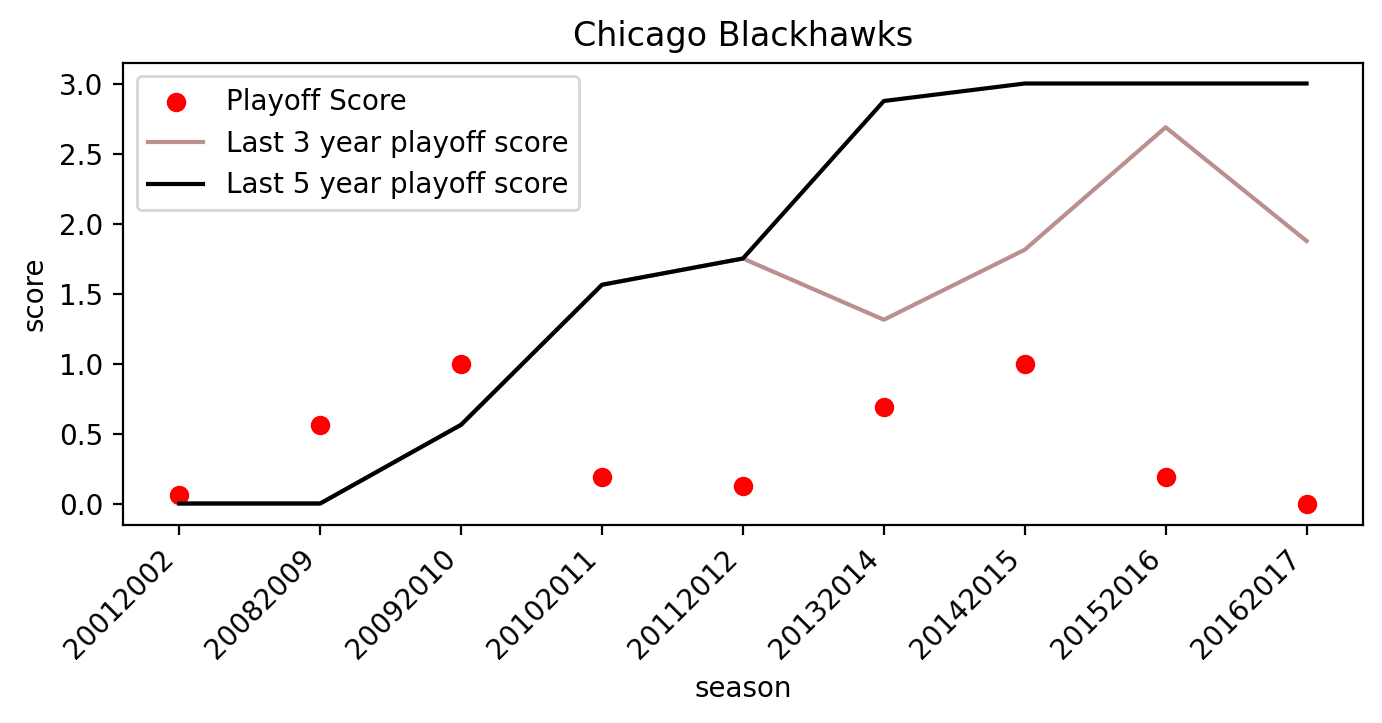

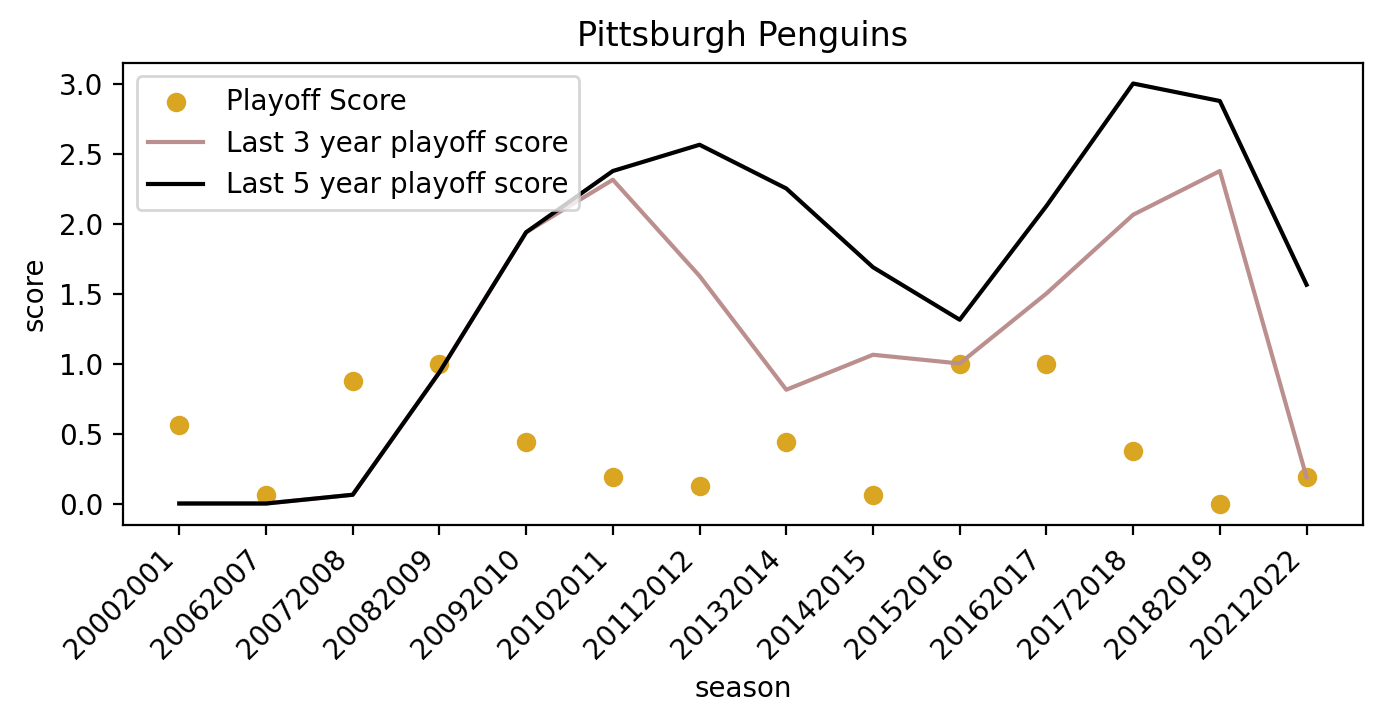

In [8]:
chi_df = df[df['teamFullName'] == 'Chicago Blackhawks']
pit_df = df[df['teamFullName'] == 'Pittsburgh Penguins']
colors = ['red', 'goldenrod']

for t_df, color in zip([chi_df, pit_df],colors):
    plt.figure()
    plt.title(t_df['teamFullName'].iloc[0])
    plt.xlabel('season')
    plt.ylabel('score')
    plt.xticks(rotation=45, ha='right')
    plt.scatter(t_df['seasonId'].astype(str), t_df['playoffScore'], label='Playoff Score', color=color)
    plt.plot(t_df['seasonId'].astype(str), t_df['last3PlayoffScore'], label='Last 3 year playoff score', color='rosybrown')
    plt.plot(t_df['seasonId'].astype(str), t_df['last5PlayoffScore'], label='Last 5 year playoff score', color='black')
    plt.legend();

For completeness we will look at how each feature compares against `playoffScore`.

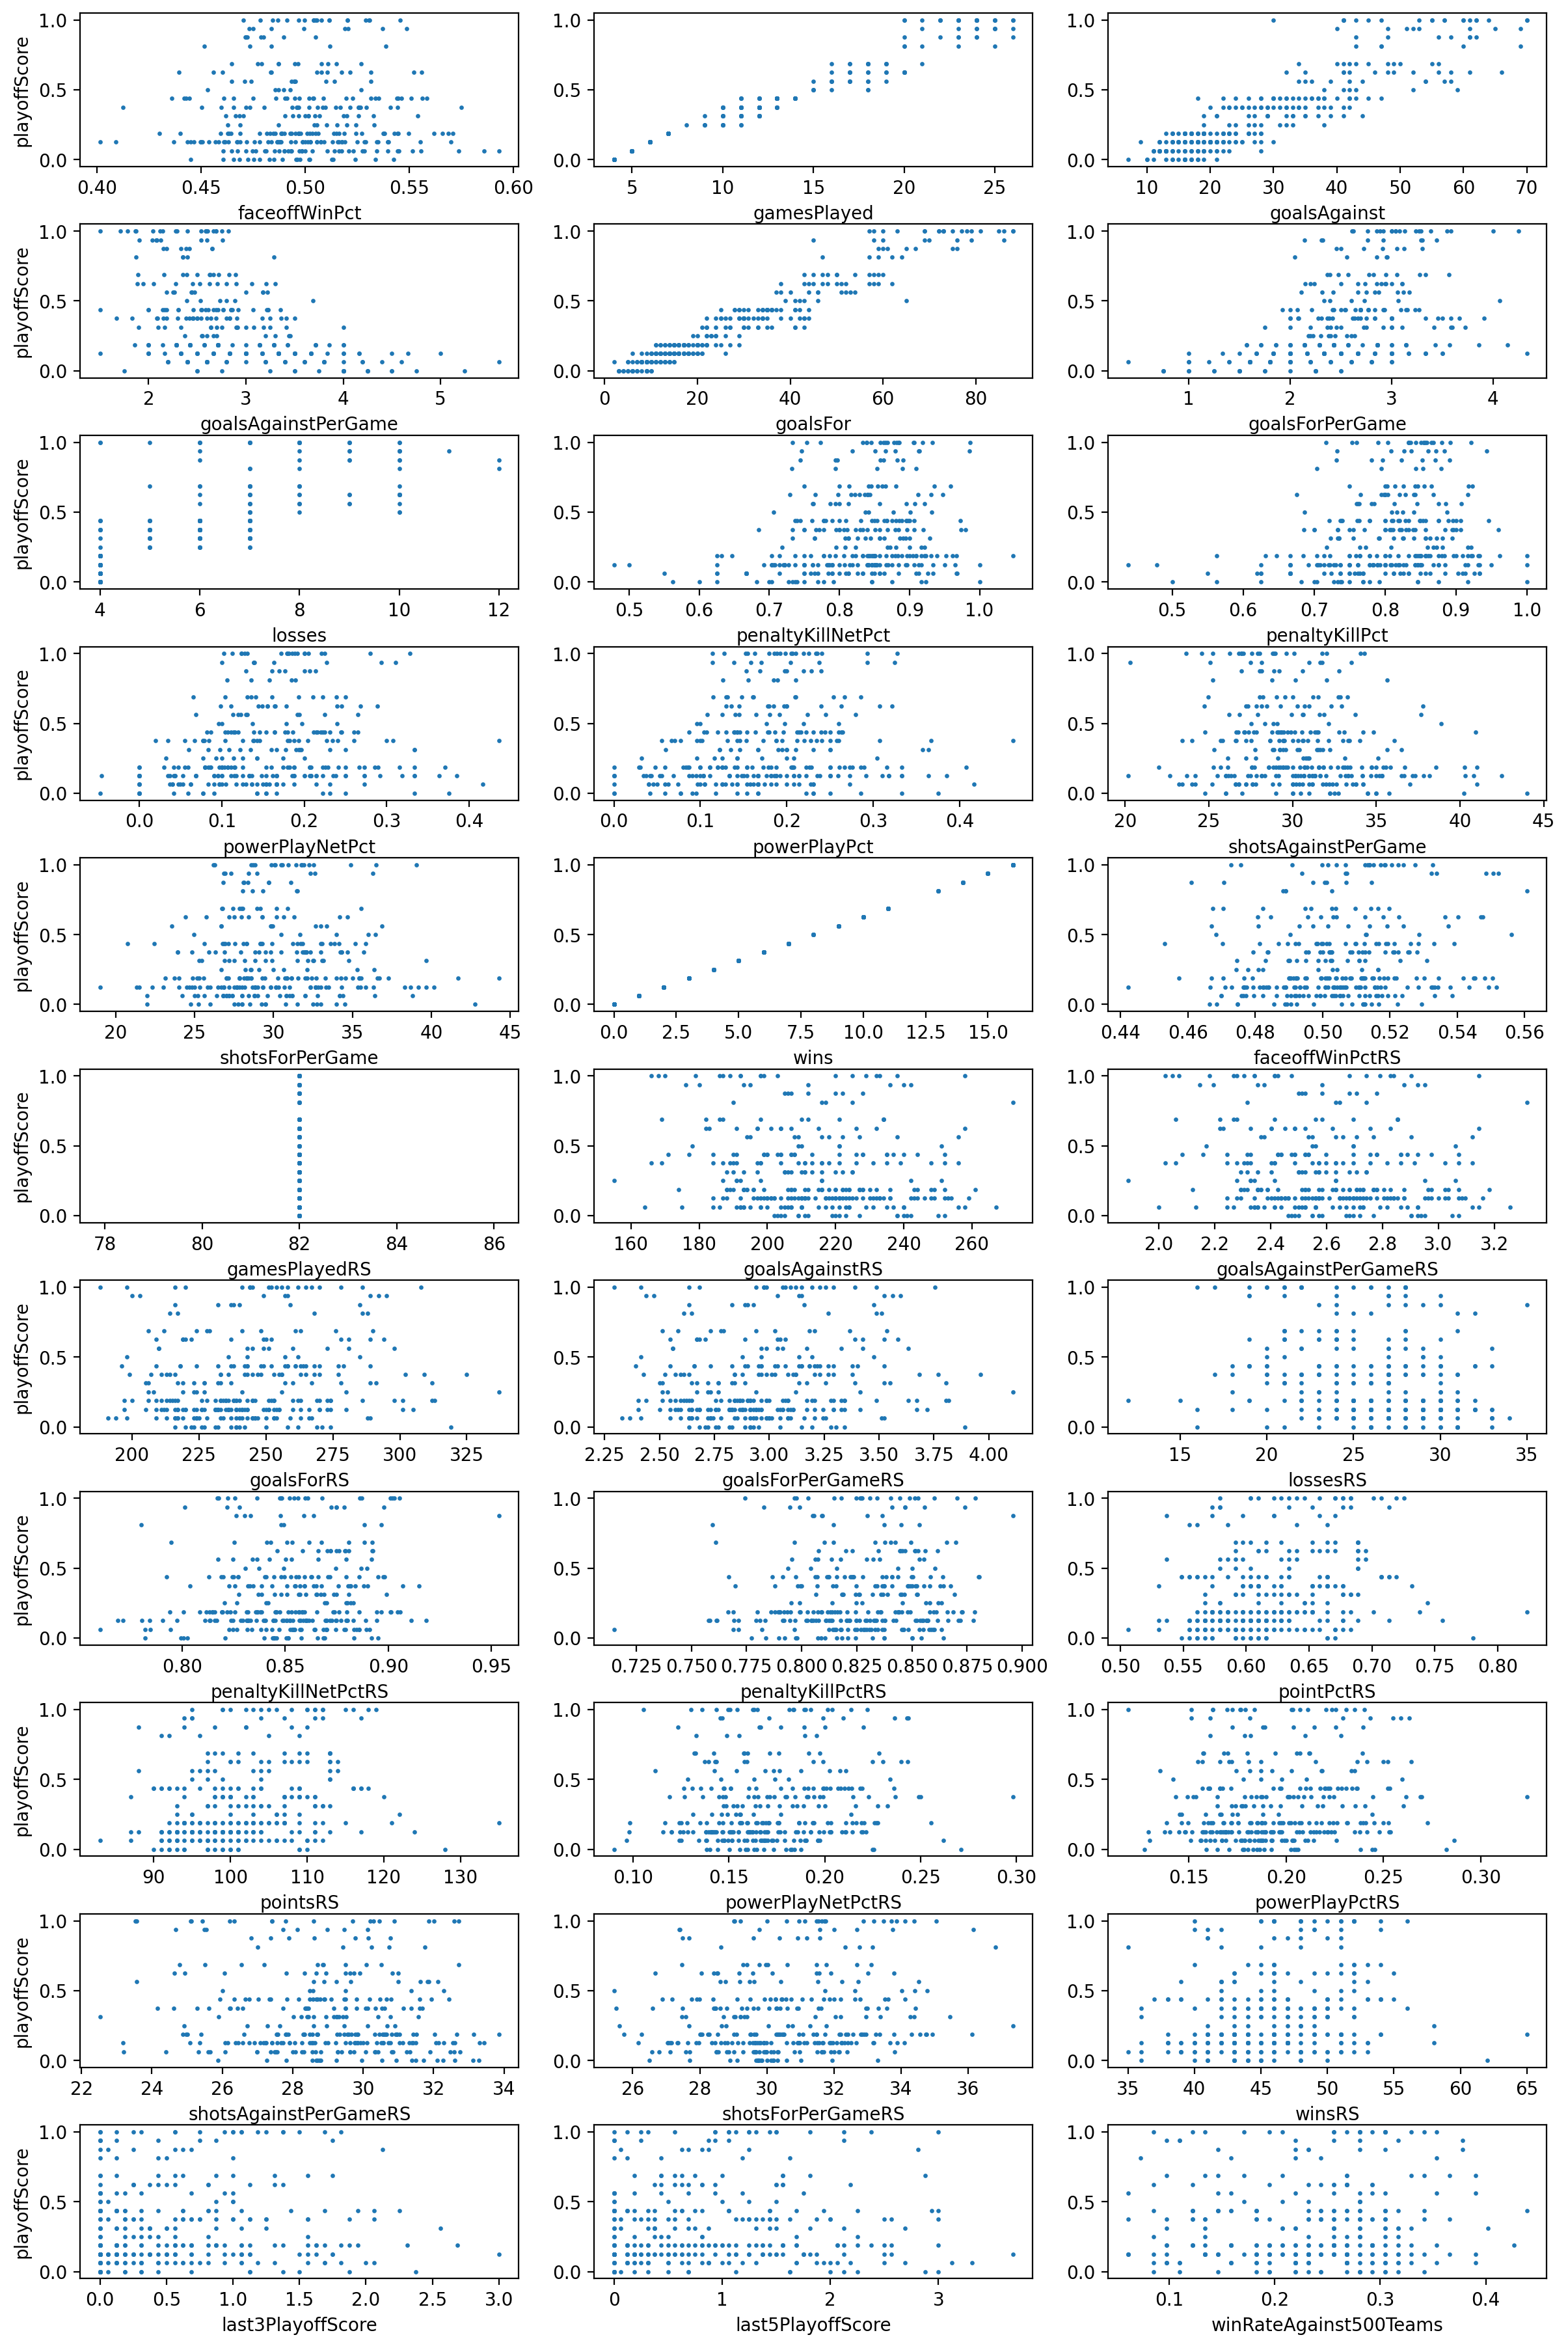

In [9]:
def playoffScoreCorrPlt(p_df, s=2):
    # don't include these features
    exclude = ['id', 'teamFullName', 'seasonId', 'teamId', 'playoffScore']
    keys = [key for key in p_df.keys() if key not in exclude]
    
    # for grid of plots
    plt_cols = 3
    plt_rows = int(np.ceil(len(keys) / plt_cols))
    fig, ax = plt.subplots(plt_rows, plt_cols, figsize=(12,18))
    fig.tight_layout()
    ax = ax.flatten()
    
    for i,key in enumerate(keys):
        ax[i].scatter(p_df[key], p_df['playoffScore'], s=s)
        ax[i].set(xlabel=key, ylabel='playoffScore' if i % plt_cols == 0 else '')

playoffScoreCorrPlt(df)

We will drop some more features that are obviously not related (or directly related) to `playoffScore` at all. We drop `goalsFor` and `goalsAgainst` because a better metric would be their per game features.

We also want to drop playoff statistics (except for `playoffScore`, `last3PlayoffScore` and `last5PlayoffScore`) since it doesn't make sense to use playoff statistics to predict a playoff winner.

In [10]:
# for when we lookup team names later
team_names = df[['teamId', 'teamFullName']].drop_duplicates()

# drop directly or not correlated features
df = df.drop(['gamesPlayedRS', 'wins', 'losses', 'goalsFor', 'goalsAgainst', 'gamesPlayed', 'teamFullName'], axis=1)

# drop playoff features
df = df.drop(['faceoffWinPct', 'goalsAgainstPerGame', 'goalsForPerGame', 
              'penaltyKillNetPct', 'penaltyKillPct', 'powerPlayNetPct',
              'powerPlayPct', 'shotsAgainstPerGame', 'shotsForPerGame'], axis=1)

team_names

,teamId,teamFullName
0,28,San Jose Sharks
1,15,Washington Capitals
2,1,New Jersey Devils
3,5,Pittsburgh Penguins
4,17,Detroit Red Wings
5,4,Philadelphia Flyers
6,12,Carolina Hurricanes
7,23,Vancouver Canucks
8,21,Colorado Avalanche
9,25,Dallas Stars


## Choosing a model

We are trying to predict what team is most likely to win the Stanley Cup in a given year, i.e., which team will have a `playoffScore` of 1.0. More generally, we would like to see the predicted playoff score for a given set of teams.

This is a regression task, since our model will predict a continuous number between 0 and 1.

Some models we will try are:

**Lasso**

Only a few features may be important, so Lasso can make these selections for us. 

The downside is that Lasso is a linear model, and we may require a more complex model

**Kernelized SVMs**

Complex decision boundaries can be made, and works well with both low and high-dimensional data. SVMs were also used before for a similar problem in [this](http://dx.doi.org/10.1515/jqas-2014-0093) academic paper.

We will need to scale our data in order to use SVMs.

**Gradient Boosted Trees**

This model will continuously learn and correct itself, and is likely to produce the most accurate result.

Although, Gradient Boosted Trees will require a careful tuning of our parameters.

### Training and Testing

We don't want to do a full-random split of the dataset, in case one split has all the winners and the other has none. We want to randomly split by the season (so for example, training contains seasons 2000-2010, 2018-2025 and testing has 2010-2018).

In [23]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.25)
X = df.drop('playoffScore', axis=1)
y = df['playoffScore']
split = gss.split(X, y, groups=df['seasonId'])

train, test = next(split)
train, test = df.iloc[train], df.iloc[test]

X_train = train.drop('playoffScore', axis=1)
X_test = test.drop('playoffScore', axis=1)
y_train = train['playoffScore']
y_test = test['playoffScore']

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

[x for x in X_train['seasonId'].unique() if x in X_test['seasonId'].unique()]

X_train shape: (240, 21)
X_test shape: (80, 21)
y_train shape: (240,)
y_test shape: (80,)


[]

### Scaling

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.min(), X_train_scaled.max()

(0.0, 1.0000000000000004)

### Lasso

In [26]:
from sklearn.linear_model import Lasso

alphas = [0.07, 0.1, 0.5, 1, 2]
for alpha in alphas:
    lasso = Lasso(alpha=alpha).fit(X_train, y_train)

    train_score = lasso.score(X_train, y_train)
    test_score  = lasso.score(X_test, y_test)

    print(f'Lasso with α = {alpha} outputted scores of (train, test) = ({train_score:.3f}, {test_score:.3f})')

Lasso with α = 0.07 outputted scores of (train, test) = (0.095, 0.049)
Lasso with α = 0.1 outputted scores of (train, test) = (0.094, 0.050)
Lasso with α = 0.5 outputted scores of (train, test) = (0.072, 0.049)
Lasso with α = 1 outputted scores of (train, test) = (0.010, 0.003)
Lasso with α = 2 outputted scores of (train, test) = (0.000, 0.000)


Obviously Lasso produced some pretty poor results. Let's try the other models.

### Kernelized SVMs

In [34]:
from sklearn.svm import SVR

gammas = ['scale', 0.01, 0.1, 1]

Cs = [0.1, 1, 2]

for gamma in gammas:
    for C in Cs:
        svr = SVR(gamma=gamma, C=C).fit(X_train_scaled, y_train)

        train_score = svr.score(X_train_scaled, y_train)
        test_score  = svr.score(X_test_scaled, y_test)

        print(f'SVR with γ = {gamma}, C = {C} outputted scores of (train, test) = ({train_score:.3f}, {test_score:.3f})')
    print()

SVR with γ = scale, C = 0.1 outputted scores of (train, test) = (0.191, 0.077)
SVR with γ = scale, C = 1 outputted scores of (train, test) = (0.567, -0.154)
SVR with γ = scale, C = 2 outputted scores of (train, test) = (0.691, -0.306)

SVR with γ = 0.01, C = 0.1 outputted scores of (train, test) = (-0.028, -0.032)
SVR with γ = 0.01, C = 1 outputted scores of (train, test) = (0.044, 0.038)
SVR with γ = 0.01, C = 2 outputted scores of (train, test) = (0.061, 0.052)

SVR with γ = 0.1, C = 0.1 outputted scores of (train, test) = (0.046, 0.036)
SVR with γ = 0.1, C = 1 outputted scores of (train, test) = (0.133, 0.063)
SVR with γ = 0.1, C = 2 outputted scores of (train, test) = (0.171, 0.056)

SVR with γ = 1, C = 0.1 outputted scores of (train, test) = (0.196, 0.077)
SVR with γ = 1, C = 1 outputted scores of (train, test) = (0.580, -0.155)
SVR with γ = 1, C = 2 outputted scores of (train, test) = (0.704, -0.314)



### Gradient Boosted Trees

In [37]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

gbr = RandomForestRegressor().fit(X_train_scaled, y_train)

gbr.score(X_train_scaled, y_train), gbr.score(X_test_scaled, y_test)

(0.8633789202887605, 0.07595421546444192)

By default `GradientBoostingRegressor` produced a very overfit model. Let's try to adjust the parameters to fix this

In [46]:
# learning rates
LRs = [0.01, 0.1, 0.5, 1.0]

# n_estimators
NEs = [20, 50, 100, 250, 300]

for learning_rate in LRs:
    for n_estimators in NEs:
        gbr = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators).fit(X_train_scaled, y_train)
    
        train_score = gbr.score(X_train_scaled, y_train)
        test_score = gbr.score(X_test_scaled, y_test)
    
        print(f'GBR with learning_rate = {learning_rate}, n_estimators = {n_estimators} outputted scores of (train, test) = ({train_score:.3f}, {test_score:.3f})')
    print()

GBR with learning_rate = 0.01, n_estimators = 20 outputted scores of (train, test) = (0.088, 0.021)
GBR with learning_rate = 0.01, n_estimators = 50 outputted scores of (train, test) = (0.186, 0.043)
GBR with learning_rate = 0.01, n_estimators = 100 outputted scores of (train, test) = (0.306, 0.051)
GBR with learning_rate = 0.01, n_estimators = 250 outputted scores of (train, test) = (0.494, 0.012)
GBR with learning_rate = 0.01, n_estimators = 300 outputted scores of (train, test) = (0.534, 0.008)

GBR with learning_rate = 0.1, n_estimators = 20 outputted scores of (train, test) = (0.463, 0.001)
GBR with learning_rate = 0.1, n_estimators = 50 outputted scores of (train, test) = (0.663, -0.045)
GBR with learning_rate = 0.1, n_estimators = 100 outputted scores of (train, test) = (0.859, -0.072)
GBR with learning_rate = 0.1, n_estimators = 250 outputted scores of (train, test) = (0.986, -0.117)
GBR with learning_rate = 0.1, n_estimators = 300 outputted scores of (train, test) = (0.993, -0